# 

In [61]:
from spatial_filtering import arrays, constants, simulation
import numpy as np
import matplotlib.pyplot as plt

import importlib

importlib.reload(arrays)
importlib.reload(constants)
importlib.reload(simulation)

num_antenna = 10
num_frequencies = 1
f_bandwidth_mhz = 0.25
f_low= 1e9 - f_bandwidth_mhz * 1e6
f_high = 1e9 + f_bandwidth_mhz * 1e6

fs = 4e6
mid_freq = 1e9

#f = np.array([f_base + n * f_diff for n in range(num_frequencies)])
wv = [constants.c / (1e9 + 1e6)]
d  = wv[0]/2

source_f_low = f_low
source_f_high = f_high
interferer_f_low = [1e9 + 1e6 - 0.25e6]
interferer_f_high = [1e9 + 1e6 + 0.25e6]
source_theta_signal_deg = 40
interferer_theta_signal_deg = [20]
source_amplitude = 20
interferer_amplitude = [100]

array = arrays.UniformLinearArray(num_antenna, d)

t = np.linspace(0, 1001 / fs, 1_000)

#X_true = np.array([simulation.simulate(array, source_f, [], source_theta_signal_deg, [], source_amplitude, [], t, sigma=0)])
X = np.array([simulation.simulate(array, source_f_low, source_f_high, 
                                  interferer_f_low, interferer_f_high, source_theta_signal_deg, interferer_theta_signal_deg,
                                  source_amplitude, interferer_amplitude, t, sigma=0.05, center_freq=1e9, sampling_frequency = fs)])
channel = 0
acm = X[channel, :, :] @ X[channel, :, :].conj().T#/ (len(t) - 1)
evals, evecs = np.linalg.eigh(acm)

num_interferers = 1


In [62]:
def plot_spectrum(signals, labels, fs, f_carrier, true_signal):
    fig, axes = plt.subplots(1, len(labels), figsize=(20, 10))

    ##true_fft_vals = np.fft.fftshift(np.fft.fft(true_signal))
    #true_power_spectrum = np.abs(true_fft_vals) ** 2
    #true_power_db = 10 * np.log10(
    #    true_power_spectrum + 1e-12
    #)  # Adding small number to avoid log(0)
    #true_power_db -= true_power_db.max()

    for i, (signal, label) in enumerate(zip(signals, labels)):
        # FFT along time axis
        fft_vals = np.fft.fftshift(np.fft.fft(signal))
        fft_freq = np.fft.fftshift(np.fft.fftfreq(len(signal), d=1 / fs))
        power_spectrum = np.abs(fft_vals) ** 2
        power_db = 10 * np.log10(
            power_spectrum + 1e-12
        )  # Adding small number to avoid log(0)
        power_db -= np.max(power_db)
        if len(labels) == 1:
            ax = axes
        else:
            ax =axes[i]
        
        ax.plot(fft_freq, power_db, label=label)
        ax.set_xlabel("Frequency (Hz)")
        ax.set_ylabel("Power (dB)")
        ax.set_title(f"Power Spectrum {label}")
        ax.grid(True)
        # axes[0, i].axvline(
        #    f_carrier,
        #    color="red",
        #    linestyle="--",
        #    label=f"Carrier: {f_carrier / 1e3:.1f} kHz",
        # )

       # axes[1, i].plot(fft_freq, power_db - true_power_db, label=label)
       # axes[1, i].grid(True)
       # axes[1, i].set_title(f"Diff from true power spectrum {label}")
       # axes[1, i].legend()

    plt.tight_layout()
    plt.legend()

    # Print some diagnostics
    print(f"Sampling frequency: {fs:.1f} Hz")
    print(f"Frequency resolution: {fs / len(signal):.3f} Hz")
    print(f"Nyquist frequency: {fs / 2:.1f} Hz")
    print(f"Carrier frequency: {f_carrier / 1e3:.1f} kHz")
    print(f"Beamformed signal shape: {signal.shape}")
    print(f"Signal power: {np.mean(np.abs(signal) ** 2):.2e}")

    #return fig


In [66]:
num_eigenvectors_to_null = 2
lambda_ridge = 0
A = evecs[:, -(num_eigenvectors_to_null):]
AH = A.conj().T
orth_proj = np.identity(A.shape[0]) - A @ np.linalg.inv(AH @ A) @ AH
theta_rad = np.deg2rad(source_theta_signal_deg)
w = array.steering_vector(theta_rad, np.array([constants.c / mid_freq]))

oblique_proj = w @ np.linalg.inv(w.conj().T @ orth_proj @ w) @ w.conj().T @ orth_proj

Pw = (
    np.identity(A.shape[0])
    - w
    @ np.linalg.inv(w.conj().T @ w + lambda_ridge * np.identity(w.shape[1]))
    @ w.conj().T
)
PwA = Pw @ A
new_proj = (
    np.identity(PwA.shape[0])
    - PwA
    @ np.linalg.inv(PwA.conj().T @ PwA + lambda_ridge * np.identity(PwA.shape[1]))
    @ PwA.conj().T
)


In [67]:
w_int = array.steering_vector(np.deg2rad(interferer_theta_signal_deg[0]),constants.c/mid_freq)

In [71]:
np.abs(w_int.conj().T @ A) / np.linalg.norm(w_int)

array([0.05243952, 0.99861944])

In [73]:
np.abs(w.conj().T @ A)  / np.linalg.norm(w)

array([[0.96263544, 0.27080057]])

In [74]:
np.abs(w_int.conj().T @ PwA)

array([0.83537169, 2.9695616 ])

In [77]:
np.abs(w.conj().T @ new_proj @ X) / np.linalg.norm(w)

array([[[25.60574405, 22.22306262, 11.48265085, 10.80363171,
         11.05599466,  3.02738367,  9.2450632 ,  9.40989555,
          9.47097294, 13.11345141,  6.15155164,  8.84663441,
         19.70922382, 19.53220462, 15.48508526, 14.92560888,
         13.30173615, 13.87168853, 14.64084564, 11.23163862,
          6.30195589,  4.38986234, 11.78927312, 14.77314934,
          7.84930746, 10.77940107, 19.80068201, 16.67815408,
          7.78364606, 13.16178016, 15.03056027, 11.20258411,
         13.62639219, 15.99919342, 11.1258859 ,  3.07404273,
          7.19217201,  9.33201672,  6.78327495,  3.74108637,
          0.72909559,  5.31041516, 11.32766698, 10.76647207,
          3.61646587, 13.23073011, 18.9042185 , 11.59829439,
          7.56215454, 17.33464626, 14.34406158,  2.64745443,
         11.38057977, 11.50541369,  2.40592964,  5.70263954,
          5.66097148,  5.15446668,  7.32240553,  3.00574539,
          6.60980542, 11.48182248,  8.86353486,  3.03568762,
          8.52594498,  9

Sampling frequency: 4000000.0 Hz
Frequency resolution: 4000.000 Hz
Nyquist frequency: 2000000.0 Hz
Carrier frequency: 1000000.0 kHz
Beamformed signal shape: (1000,)
Signal power: 2.49e+00


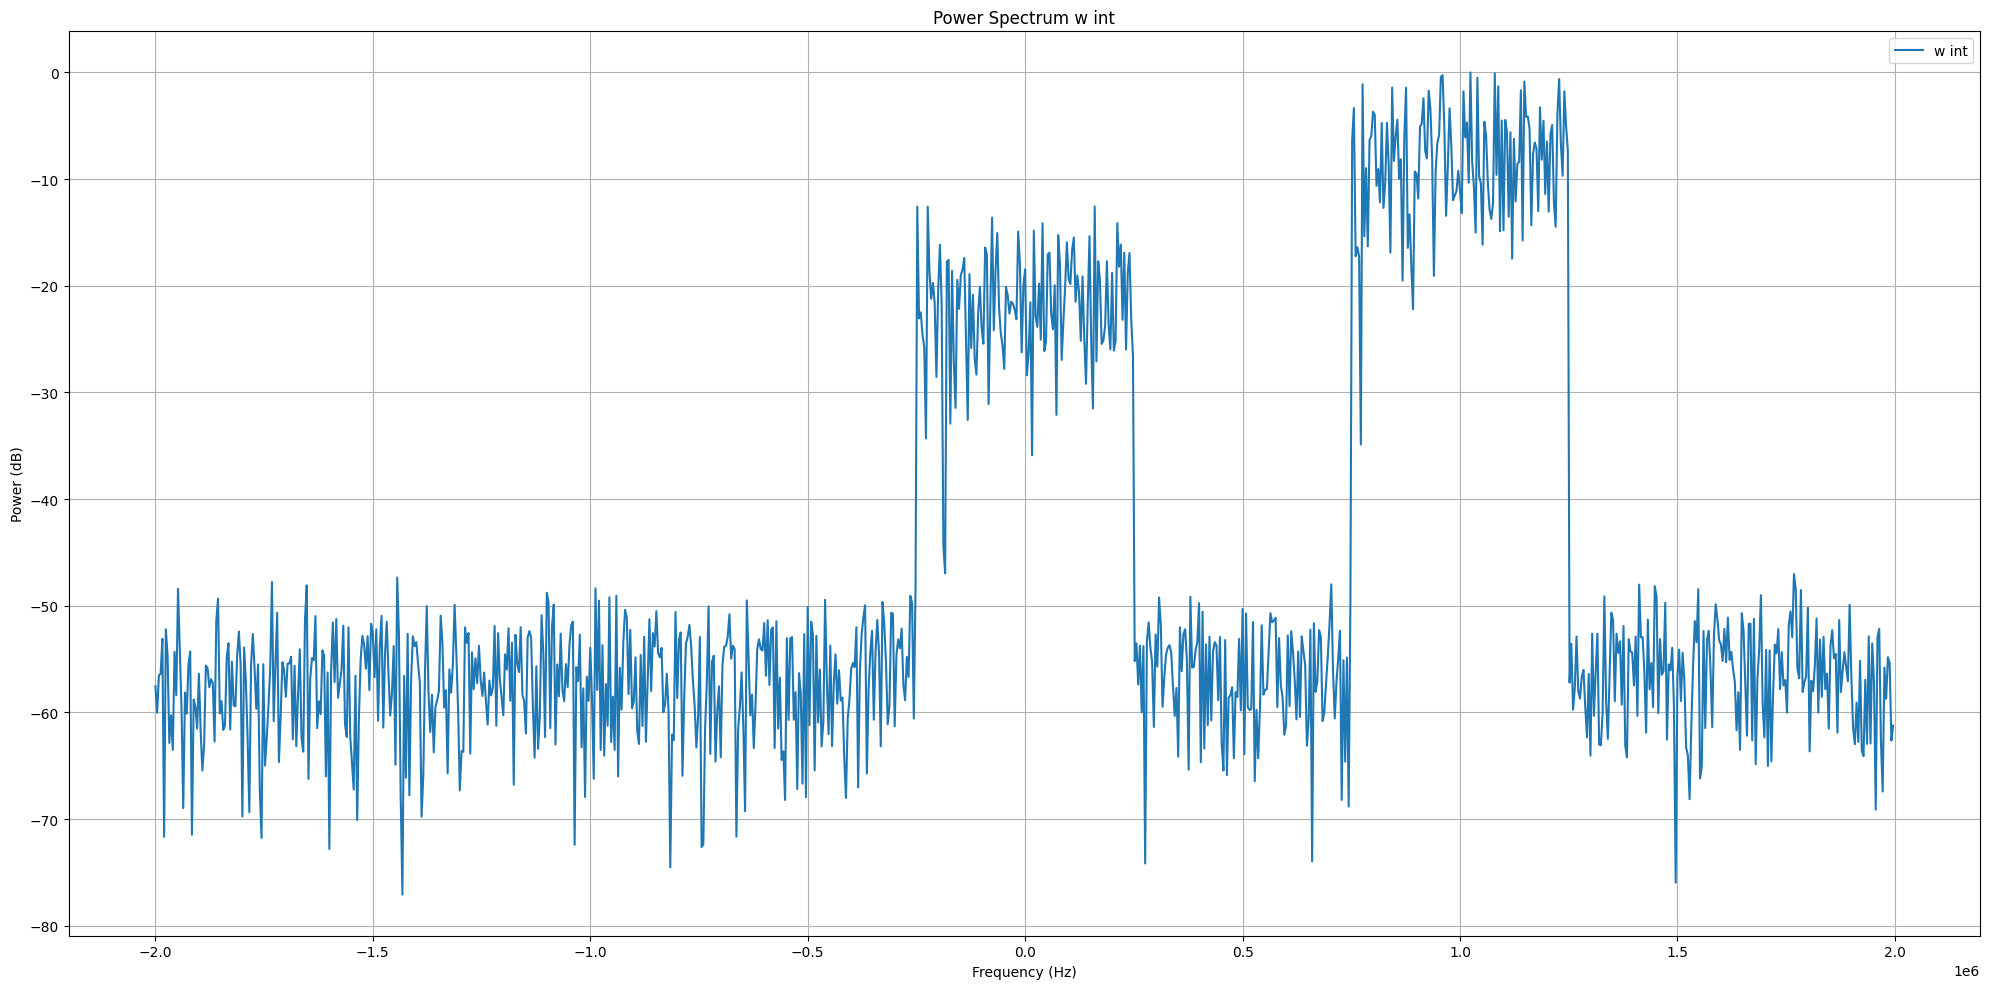

In [25]:
plot_spectrum(
    [X.mean(axis=1).flatten()], ['w int'], fs, 1e9, None)

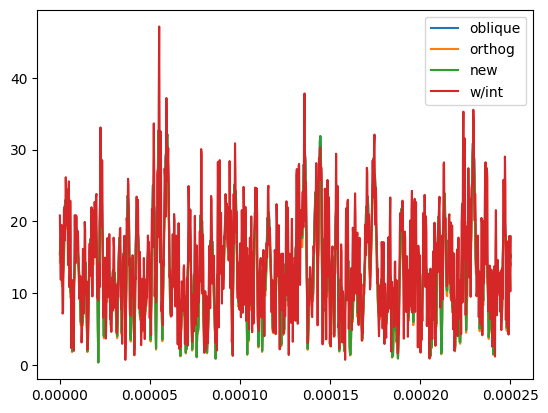

In [33]:
import matplotlib.pyplot as plt

plt.plot(t, np.abs((w.conj().T / np.linalg.norm(w) @ ((oblique_proj @ X[0]))))[0], label='oblique')
plt.plot(t, np.abs((w.conj().T / np.linalg.norm(w) @ ((orth_proj @ X[0]))))[0], label='orthog')
plt.plot(t, np.abs(w.conj().T / np.linalg.norm(w) @ (new_proj @ X[0]))[0], label='new')
plt.plot(t, np.abs(w.conj().T / np.linalg.norm(w)  @ X[0])[0], label='w/int')
plt.legend()

Sampling frequency: 4000000.0 Hz
Frequency resolution: 4000.000 Hz
Nyquist frequency: 2000000.0 Hz
Carrier frequency: 1000000.0 kHz
Beamformed signal shape: (1000,)
Signal power: 2.03e+02


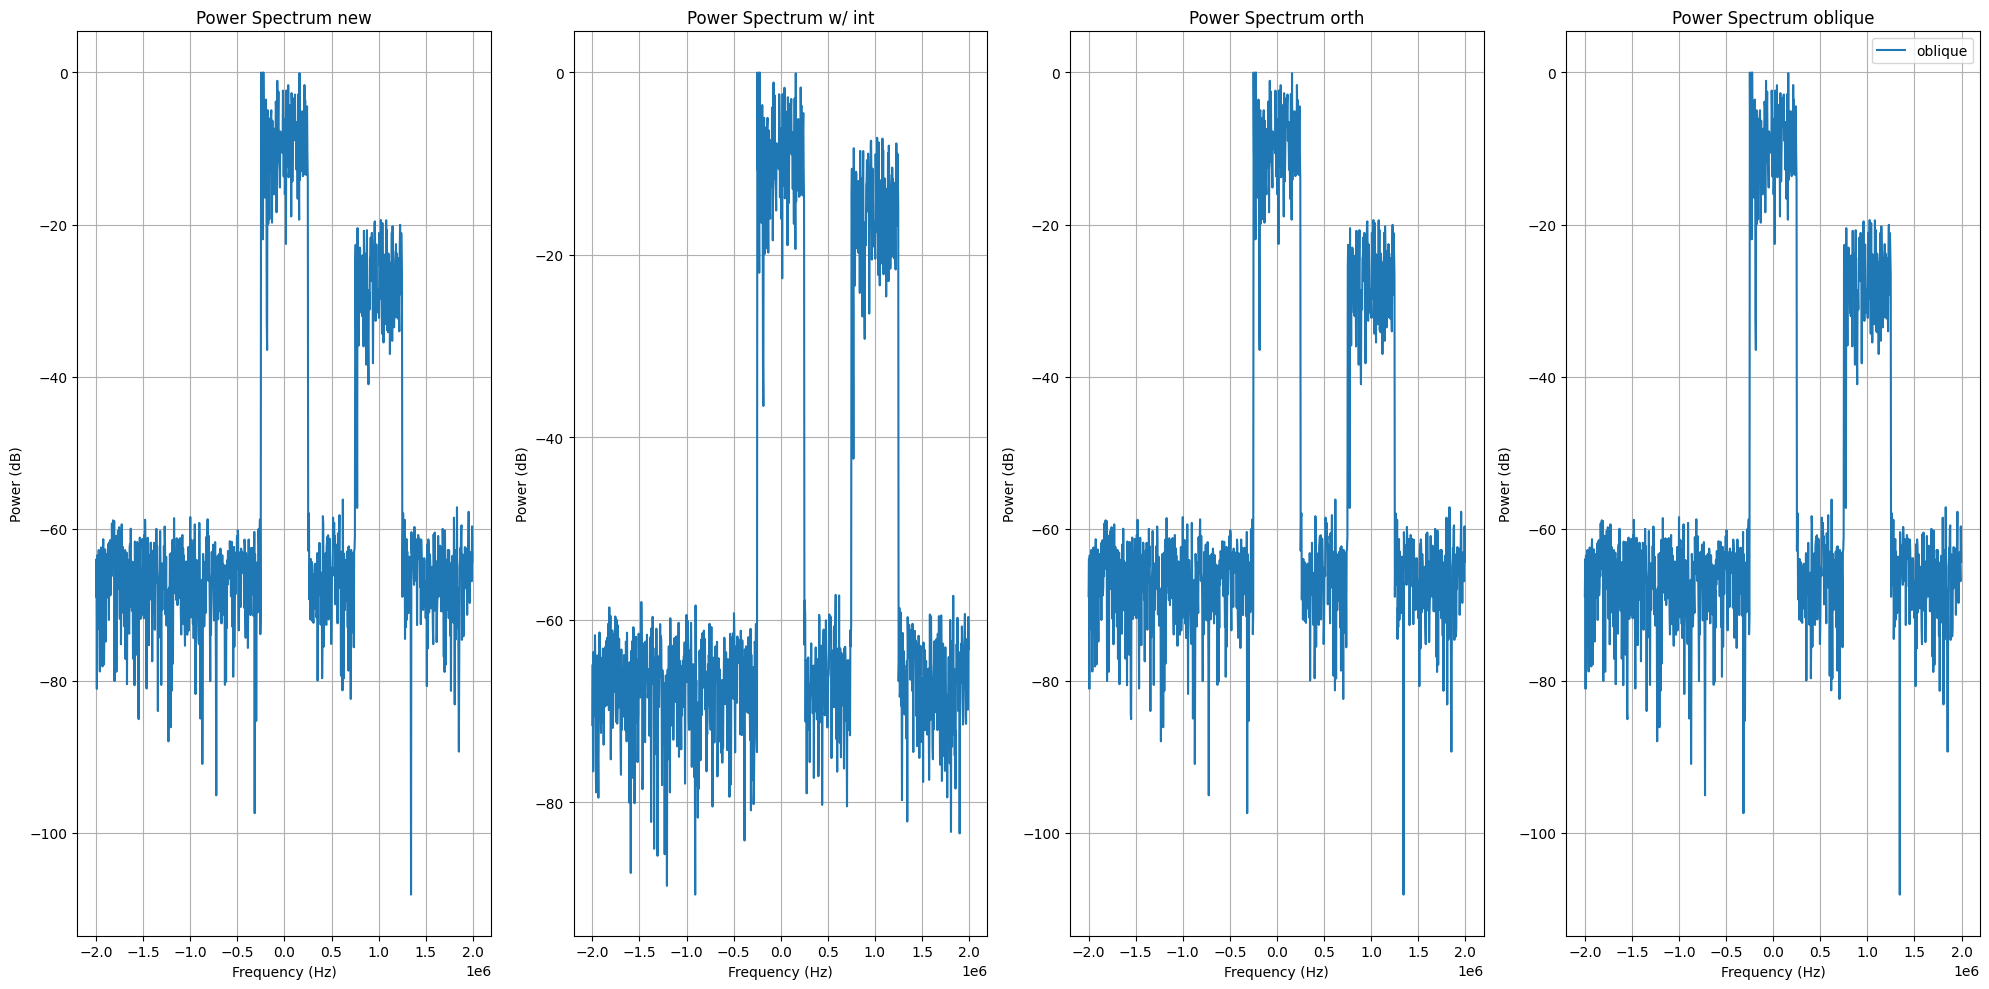

In [29]:
plot_spectrum([((w.conj().T / np.linalg.norm(w)) @ (new_proj @ X))[0].flatten(),
               ((w.conj().T / np.linalg.norm(w)) @ (X))[0].flatten(),
               ((w.conj().T / np.linalg.norm(w)) @ (orth_proj @ X))[0].flatten(),
               ((w.conj().T / np.linalg.norm(w)) @ (oblique_proj @ X))[0].flatten(),
              ], ['new',  'w/ int', 'orth', 'oblique'],fs,1e9,None,)